# County-wise Income based on US Demographic and Economic data

---

## Context

The American Community Survey (ACS) helps local officials, community leaders, and businesses understand the changes taking place in their communities. It is the premier source for detailed population and housing information about our nation.

## Problem Statement

Using the ACS 5-year county/community-wise summary data, develop a Machine Learning model to predict the Income for a county/community  

<a id="step1"></a>


# Part1: Load Data

In [1]:
# Importing Libraries
import pandas as pd 
import numpy as np

np.random.seed(42)

In [2]:
df_data = pd.read_csv('acs2017_census_tract_data.csv')

# Preview
df_data.head(3)

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7


# Part2: Data Exploration

In [3]:
df_data.shape

(74001, 37)

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6


---

Observation: 

State and County are the only Char fields

In [5]:
df_data.TractId.describe()
df_data.TractId.value_counts().mean()

1.0

In [6]:
df_data.State.describe()

count          74001
unique            52
top       California
freq            8057
Name: State, dtype: object

In [7]:
df_data.County.describe()

count                  74001
unique                  1955
top       Los Angeles County
freq                    2346
Name: County, dtype: object


---

**Observations**

1. TractId is the key field, of the type Integer. This column can be removed during Data Manipulation
2. State and County fields are category fields, they are unique and we dont observe any data errors in these fields. These can be encoded using OrdinalEncoder during Data Manipulation

### Data Exploration part 2: Understanding the column groups

Gender Fields

In [8]:
df_data.TotalPop.mean()

4384.7160173511165

In [9]:
df_data.Men.mean() + df_data.Women.mean()

4384.7160173511165

Looks like Men and Women data correctly contains the gender distribution, with no lost values

---
**Ethnicity Fields** - These are percentage fields. Lets check if the sum equals 100

In [10]:
df_data[['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']].sum(axis=1).mean()

96.5816637613008

The sum of the percentages is close to 100. The difference might be because of rounding off



---


**Employment Types**: Professional	Service	Office	Construction	Production
Check if all employment types are covered

In [11]:
df_data[['Professional',	'Service',	'Office',	'Construction',	'Production']].sum(axis=1).mean()

98.90434453588594

---
**Commute Types**: Drive	Carpool	Transit	Walk	OtherTransp	WorkAtHome
Check if all means of transport are covered


In [12]:
df_data[['Drive',	'Carpool',	'Transit',	'Walk',	'OtherTransp',	'WorkAtHome']].sum(axis=1).mean()

98.91803354008708

---
**Work Type**: PrivateWork	PublicWork	SelfEmployed	FamilyWork
Check if all worktypes are covered 

In [13]:
df_data[['PrivateWork',	'PublicWork',	'SelfEmployed',	'FamilyWork']].sum(axis=1).mean()

98.90427832056291

---
### Further Data Analysis and Data Manipulation

---
## Analysing the missing values

In [14]:
import missingno

<AxesSubplot:>

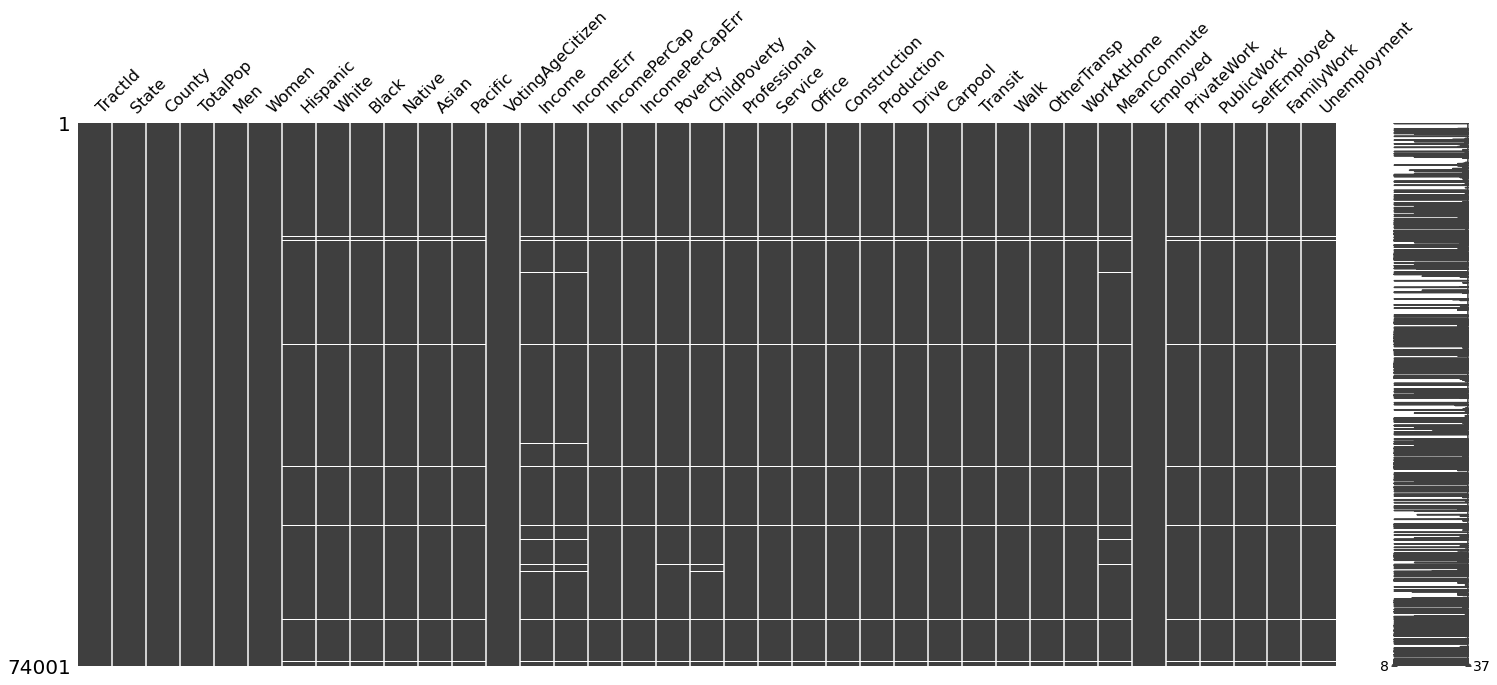

In [15]:
missingno.matrix(df_data)

<AxesSubplot:>

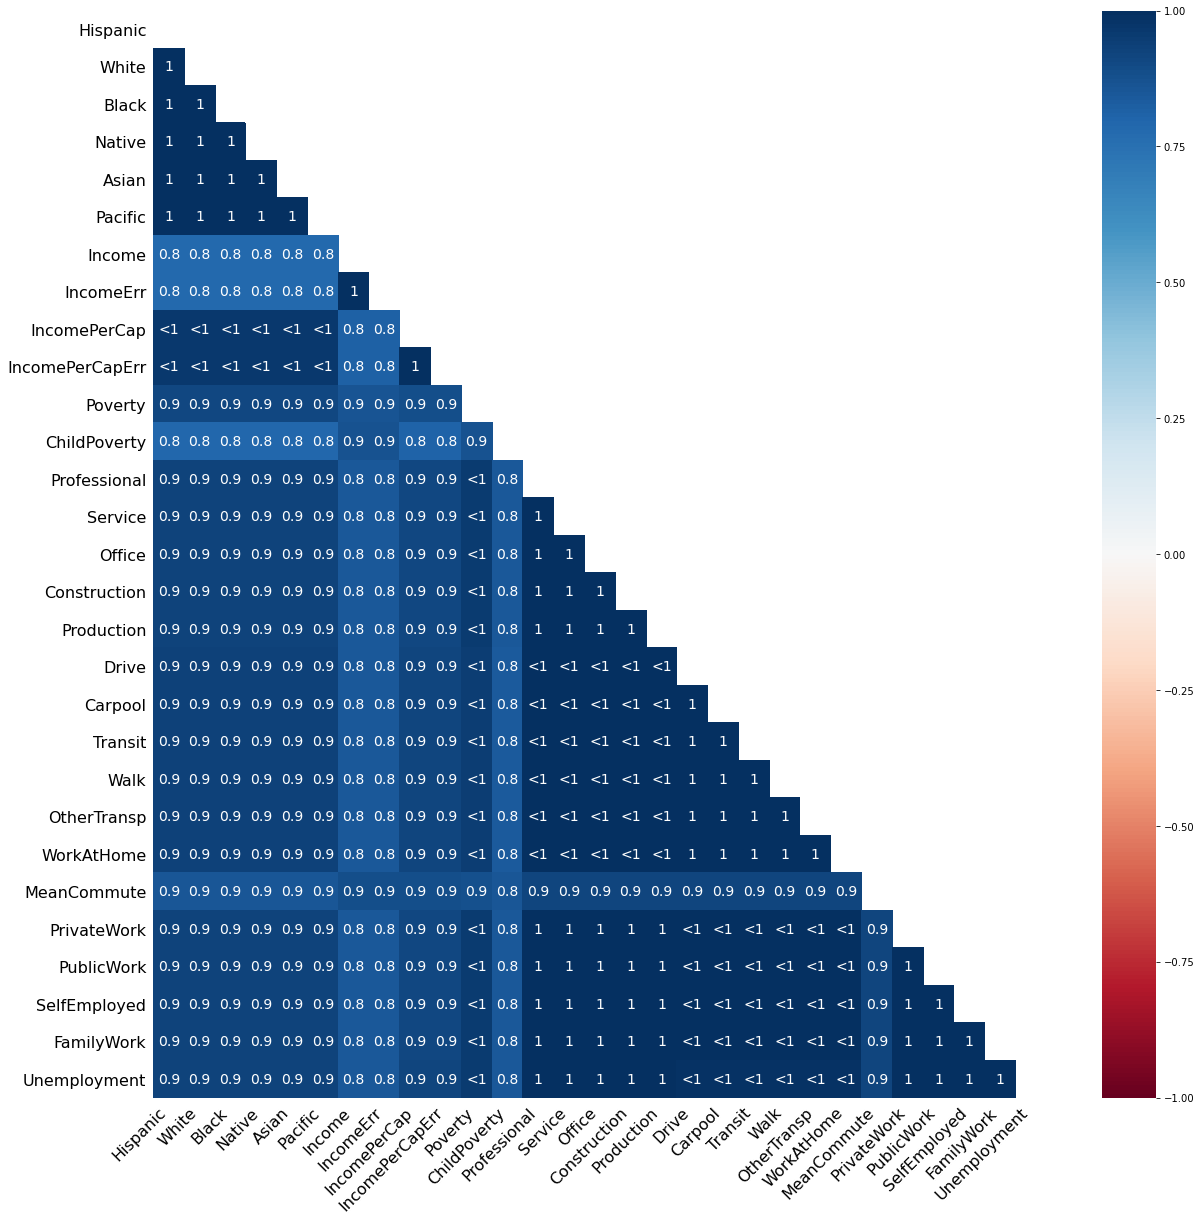

In [16]:
missingno.heatmap(df_data, filter='bottom', figsize=(20,20))

---
**Observations**

There are 696 missing values in the Ethnicity related fields, and for those records mostly all of the fields have missing values. These records can be dropped

## Dropping missing values

In [17]:
df_data = df_data.loc[df_data.Hispanic.notna()].copy()

In [18]:
df_data.shape

(73305, 37)

## Check for duplicate records

In [19]:
df_data.duplicated().sum()

0

No Duplicate records

## Some of the values are of type percentage, convert them to whole numbers

In [20]:
cols = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
for col in cols: 
    df_data[col] = df_data[col] * df_data.TotalPop / 100 

In [21]:
df_data['Poverty'] = df_data['Poverty'] * df_data['VotingAgeCitizen'] / 100

In [22]:
df_data['ChildPoverty'] = df_data['ChildPoverty'] * (df_data['TotalPop'] - df_data['VotingAgeCitizen']) / 100

In [23]:
cols = ['Professional',	'Service',	'Office',	'Construction',	'Production']
for col in cols: 
    df_data[col] = df_data[col] * df_data['Employed'] / 100

In [24]:
cols = ['Drive',	'Carpool',	'Transit',	'Walk',	'OtherTransp',	'WorkAtHome']
for col in cols: 
    df_data[col] = df_data[col] * df_data['Employed'] / 100

In [25]:
df_data.head(5)

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,44.280,1592.235,95.940,0.000,...,4.405,0.000,18.501,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,23.892,903.552,1183.740,0.000,...,0.000,4.260,0.000,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,270.800,2078.390,897.025,20.310,...,14.820,11.856,22.230,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,409.632,3426.401,302.957,21.335,...,27.735,53.621,38.829,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,89.685,7722.875,1634.260,0.000,...,38.296,14.361,33.509,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [26]:
cols = ['Employed',	'PrivateWork',	'PublicWork',	'SelfEmployed',	'FamilyWork']
for col in cols: 
    df_data[col] = df_data[col] * df_data['Employed'] / 100

In [27]:
df_data.head(5)

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,44.280,1592.235,95.940,0.000,...,4.405,0.000,18.501,24.5,7761.61,5759.11462,1645.46132,349.27245,0.00000,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,23.892,903.552,1183.740,0.000,...,0.000,4.260,0.000,22.2,7259.04,5509.61136,1088.85600,653.31360,0.00000,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,270.800,2078.390,897.025,20.310,...,14.820,11.856,22.230,23.1,21963.24,16099.05492,4634.24364,1054.23552,153.74268,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,409.632,3426.401,302.957,21.335,...,27.735,53.621,38.829,25.9,34188.01,25914.51158,6735.03797,1538.46045,0.00000,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,89.685,7722.875,1634.260,0.000,...,38.296,14.361,33.509,21.0,229153.69,163615.73466,55226.03929,10311.91605,0.00000,2.3


In [28]:
df_data.Unemployment = df_data.Unemployment * df_data.VotingAgeCitizen / 100

## Remove columns which wont have any effect on Income, or which are aggregated

In [29]:
df_data.drop(columns=['TractId', 'State','County','TotalPop', 'IncomeErr', 'IncomePerCap',	'IncomePerCapErr'], inplace=True)

In [30]:
df_data.shape

(73305, 30)

# Imputing Missing Values

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#create a new dataframe with normalized values
df_norm = pd.DataFrame(scaler.fit_transform(df_data),columns = df_data.columns) 

In [32]:
from sklearn.impute import  KNNImputer

In [33]:
#Imputing KNN with 5 neighbours
imputer = KNNImputer()

columnlist = df_norm.columns

#Fitting & transforming the imputer on the data set
df_norm[columnlist] = pd.DataFrame(imputer.fit_transform(df_norm[columnlist]),columns = [columnlist])

<AxesSubplot:>

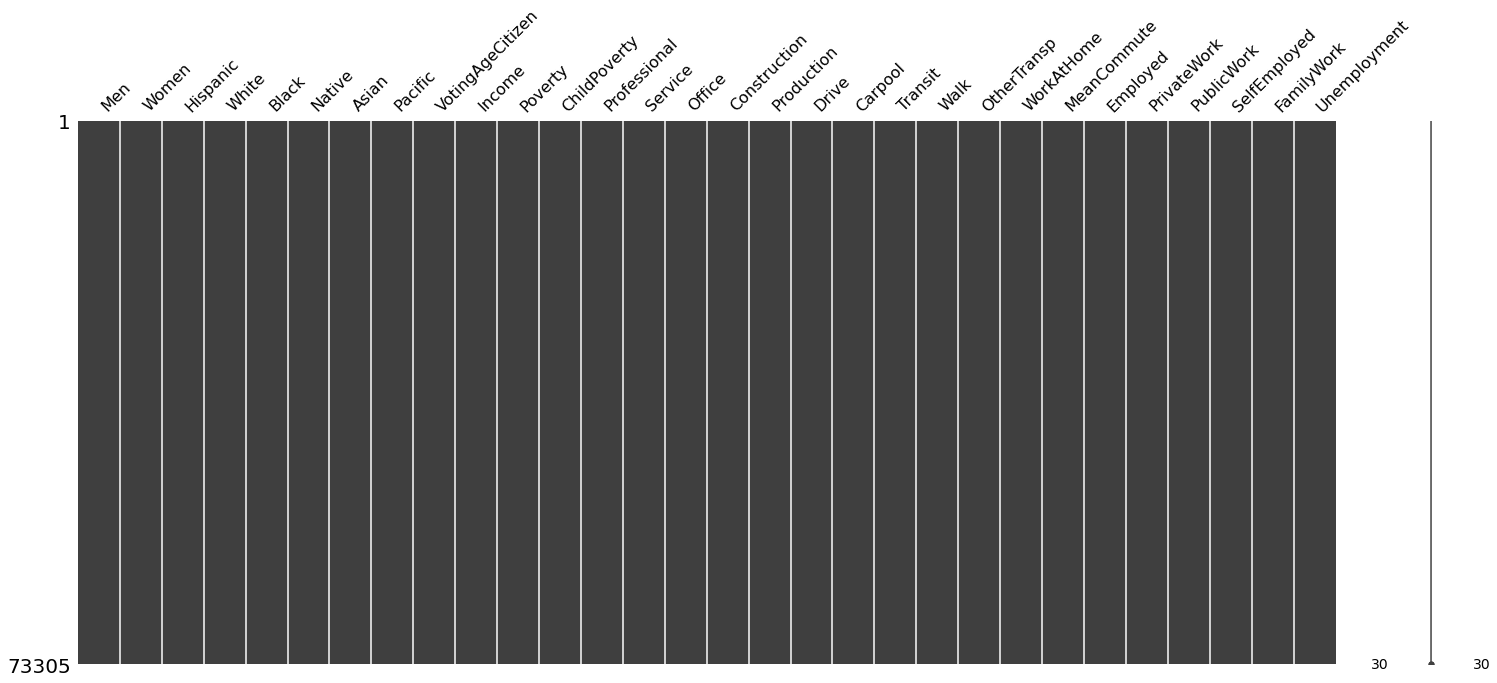

In [34]:
# Checking for missing values now
missingno.matrix(df_norm)

No missing values in the DataFrame

# Outlier Analysis

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


Visualise the outliers using IQR

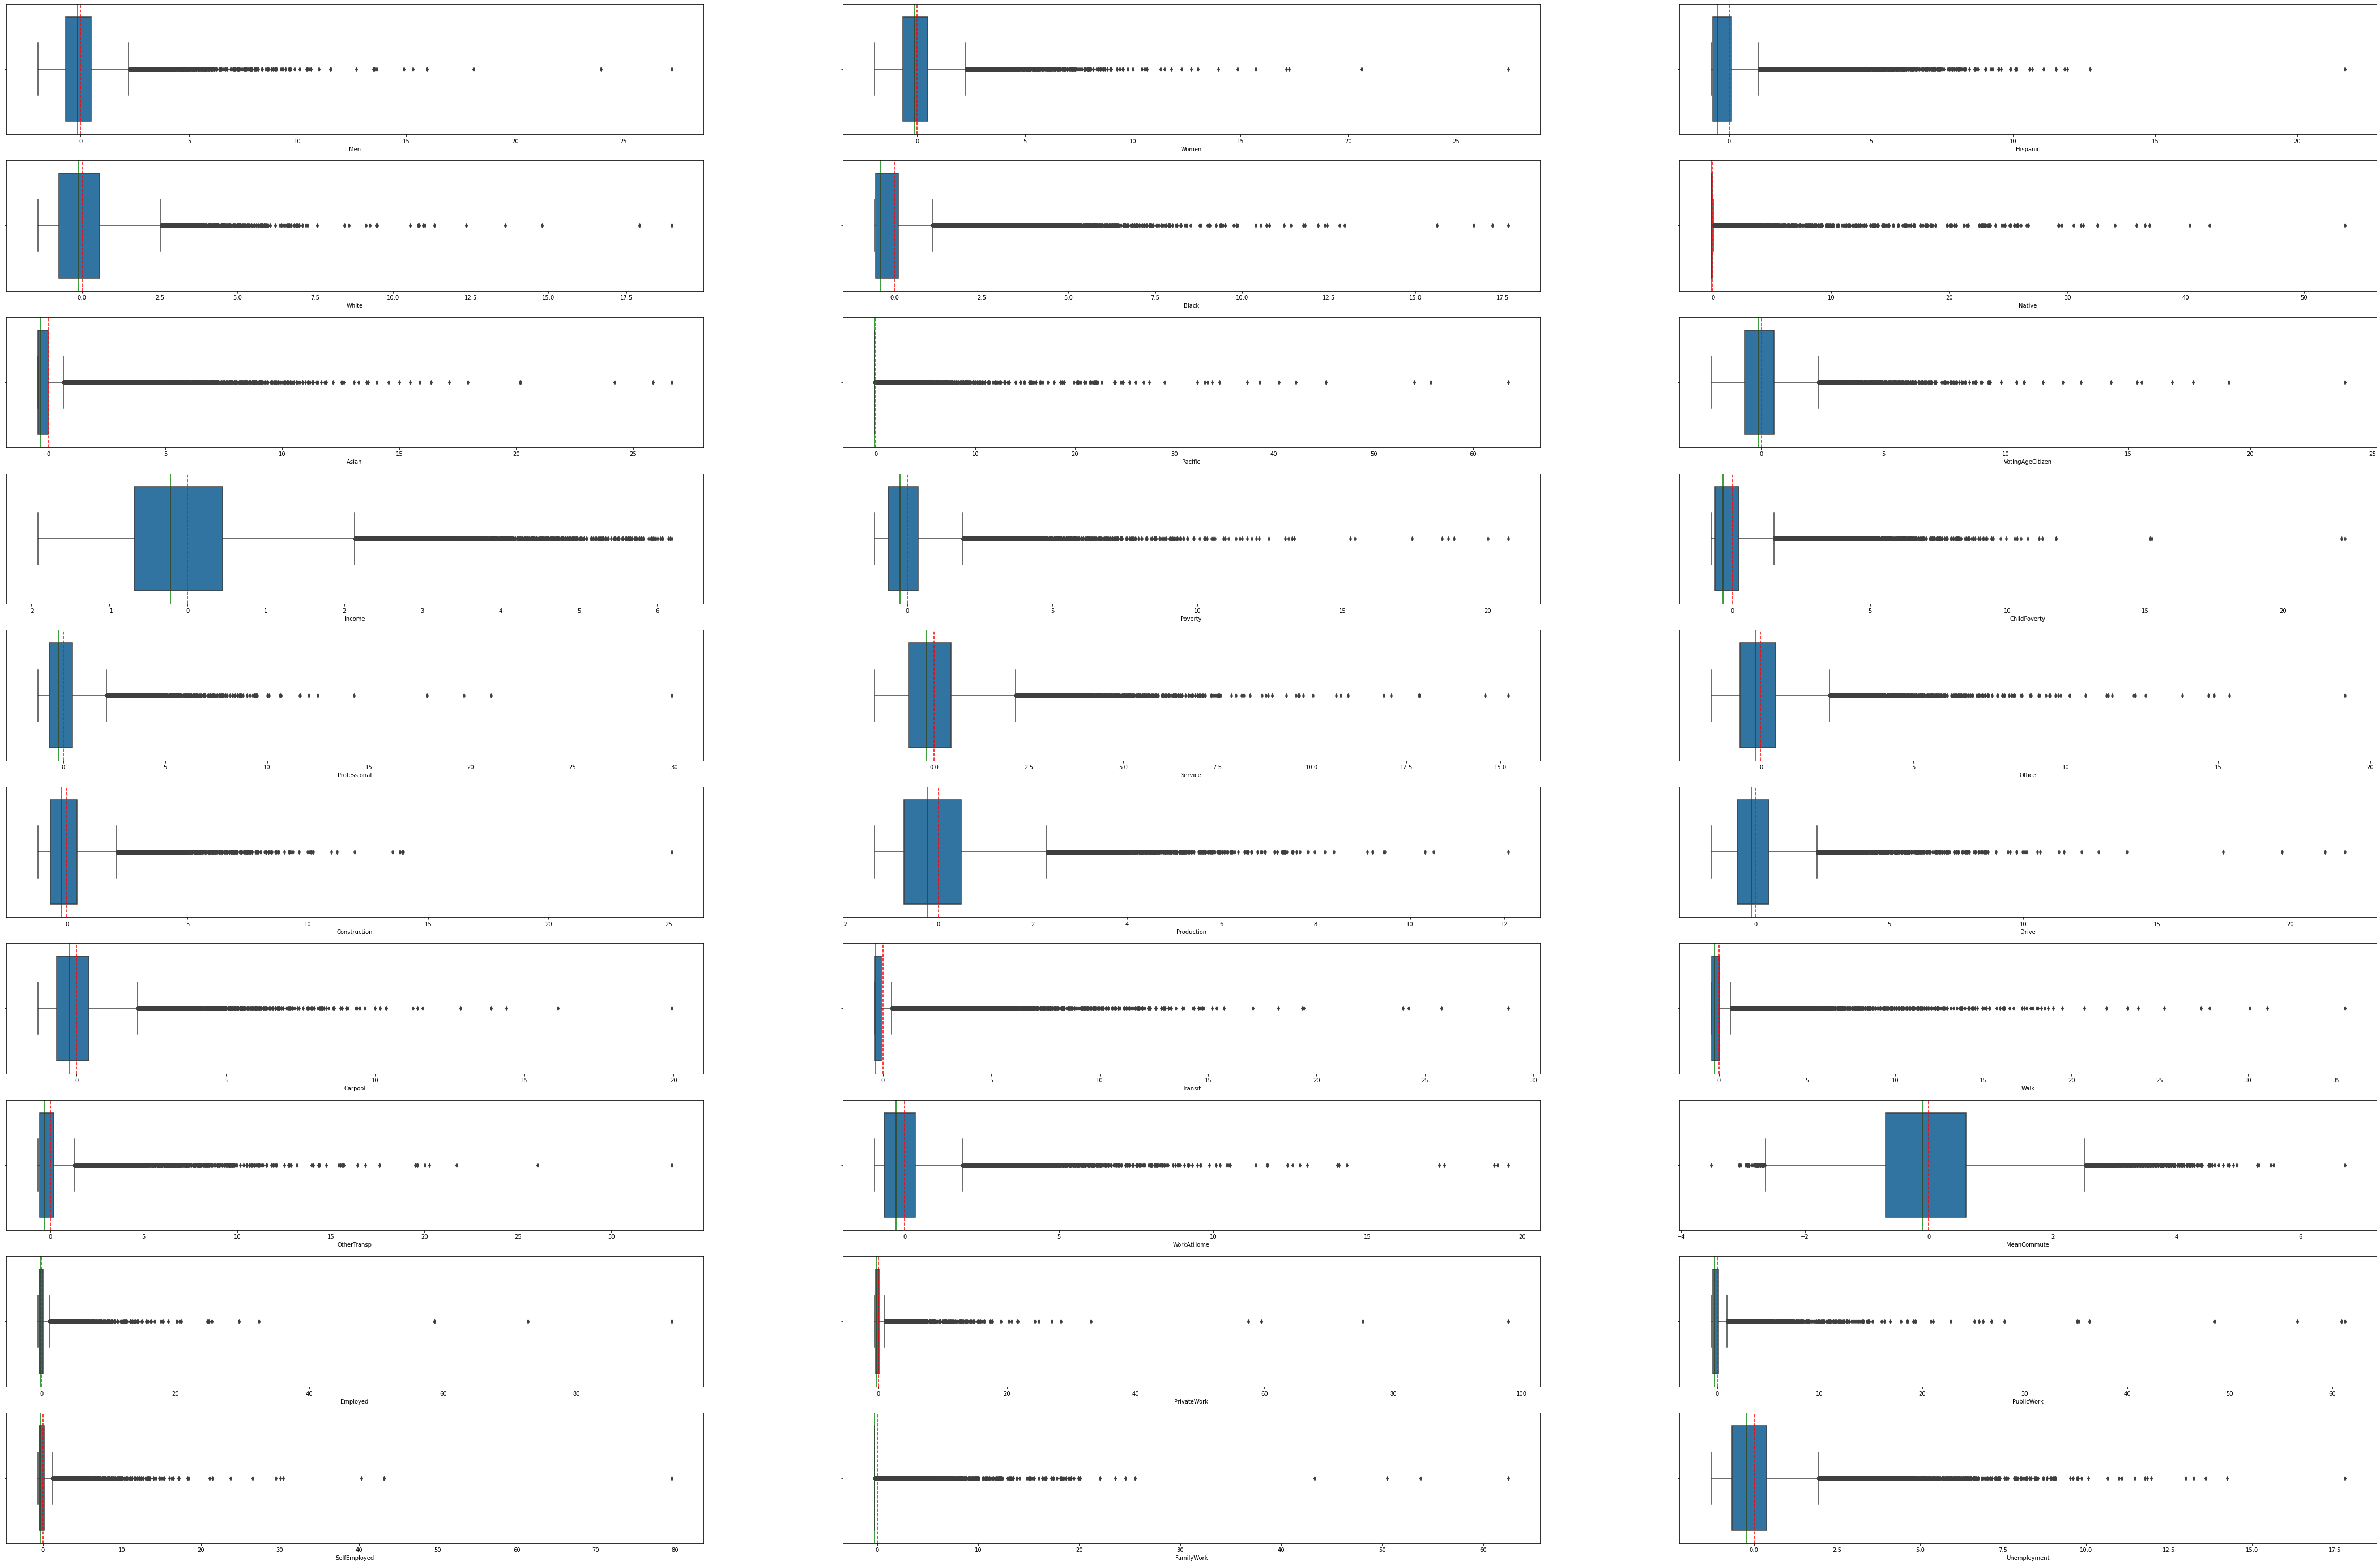

In [36]:
fig, axs = plt.subplots(10, 3, sharex=False, figsize=(75,50))


i = 0
for col in df_norm.columns.to_list():
    # print(col)

    # Take the 25 and 75 percentile points. These points will be the body of the boxplot
    # From Q1 subtract 1.5 * IQR, which will be the lower whisker
    # From Q3 add 1.5 * IQR, which will be the upper whisker
    Q1 = df_norm[col].quantile(0.25)
    Q3 = df_norm[col].quantile(0.75)

    IQR = Q3 - Q1
    lower = Q1 - IQR
    upper = Q3 + IQR

    num_out_lower = len(df_norm[df_norm < lower])
    num_out_upper = len(df_norm[df_norm > upper])

    mean = df_norm[col].mean()
    median = df_norm[col].median()

    # Plotting the boxplots

    plt_row = int(i/3)
    plt_col = (i % 3)
    i += 1
    axs_obj = axs[plt_row, plt_col]
    sns.boxplot(df_norm[col], ax=axs_obj)
    axs_obj.axvline(mean, color = 'r', linestyle='--')
    axs_obj.axvline(median, color = 'g', linestyle='-')
    # print(axs_obj)


**Conclusion** Most of the features have a lot of outliers and spanning a large range. Try Quantile Transformation of the previously normalised data

In [37]:
from sklearn.preprocessing import  QuantileTransformer

In [38]:
scaler = QuantileTransformer(random_state=0,output_distribution = 'uniform')

#create a new dataframe with normalized values
df_qt_trnsf = pd.DataFrame(scaler.fit_transform(df_norm),columns = df_norm.columns) 

df_qt_trnsf.head(2)

,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,0.070571,0.075576,0.140852,0.307240,0.415890,0.0,0.357675,0.0,0.086336,0.684773,...,0.225422,0.000000,0.153596,0.451952,0.106856,0.102325,0.210249,0.119415,0.0,0.112140
1,0.148482,0.090340,0.087879,0.186086,0.856038,0.0,0.355808,0.0,0.137137,0.268755,...,0.000000,0.219223,0.000000,0.313814,0.098765,0.097396,0.136901,0.210127,0.0,0.088627


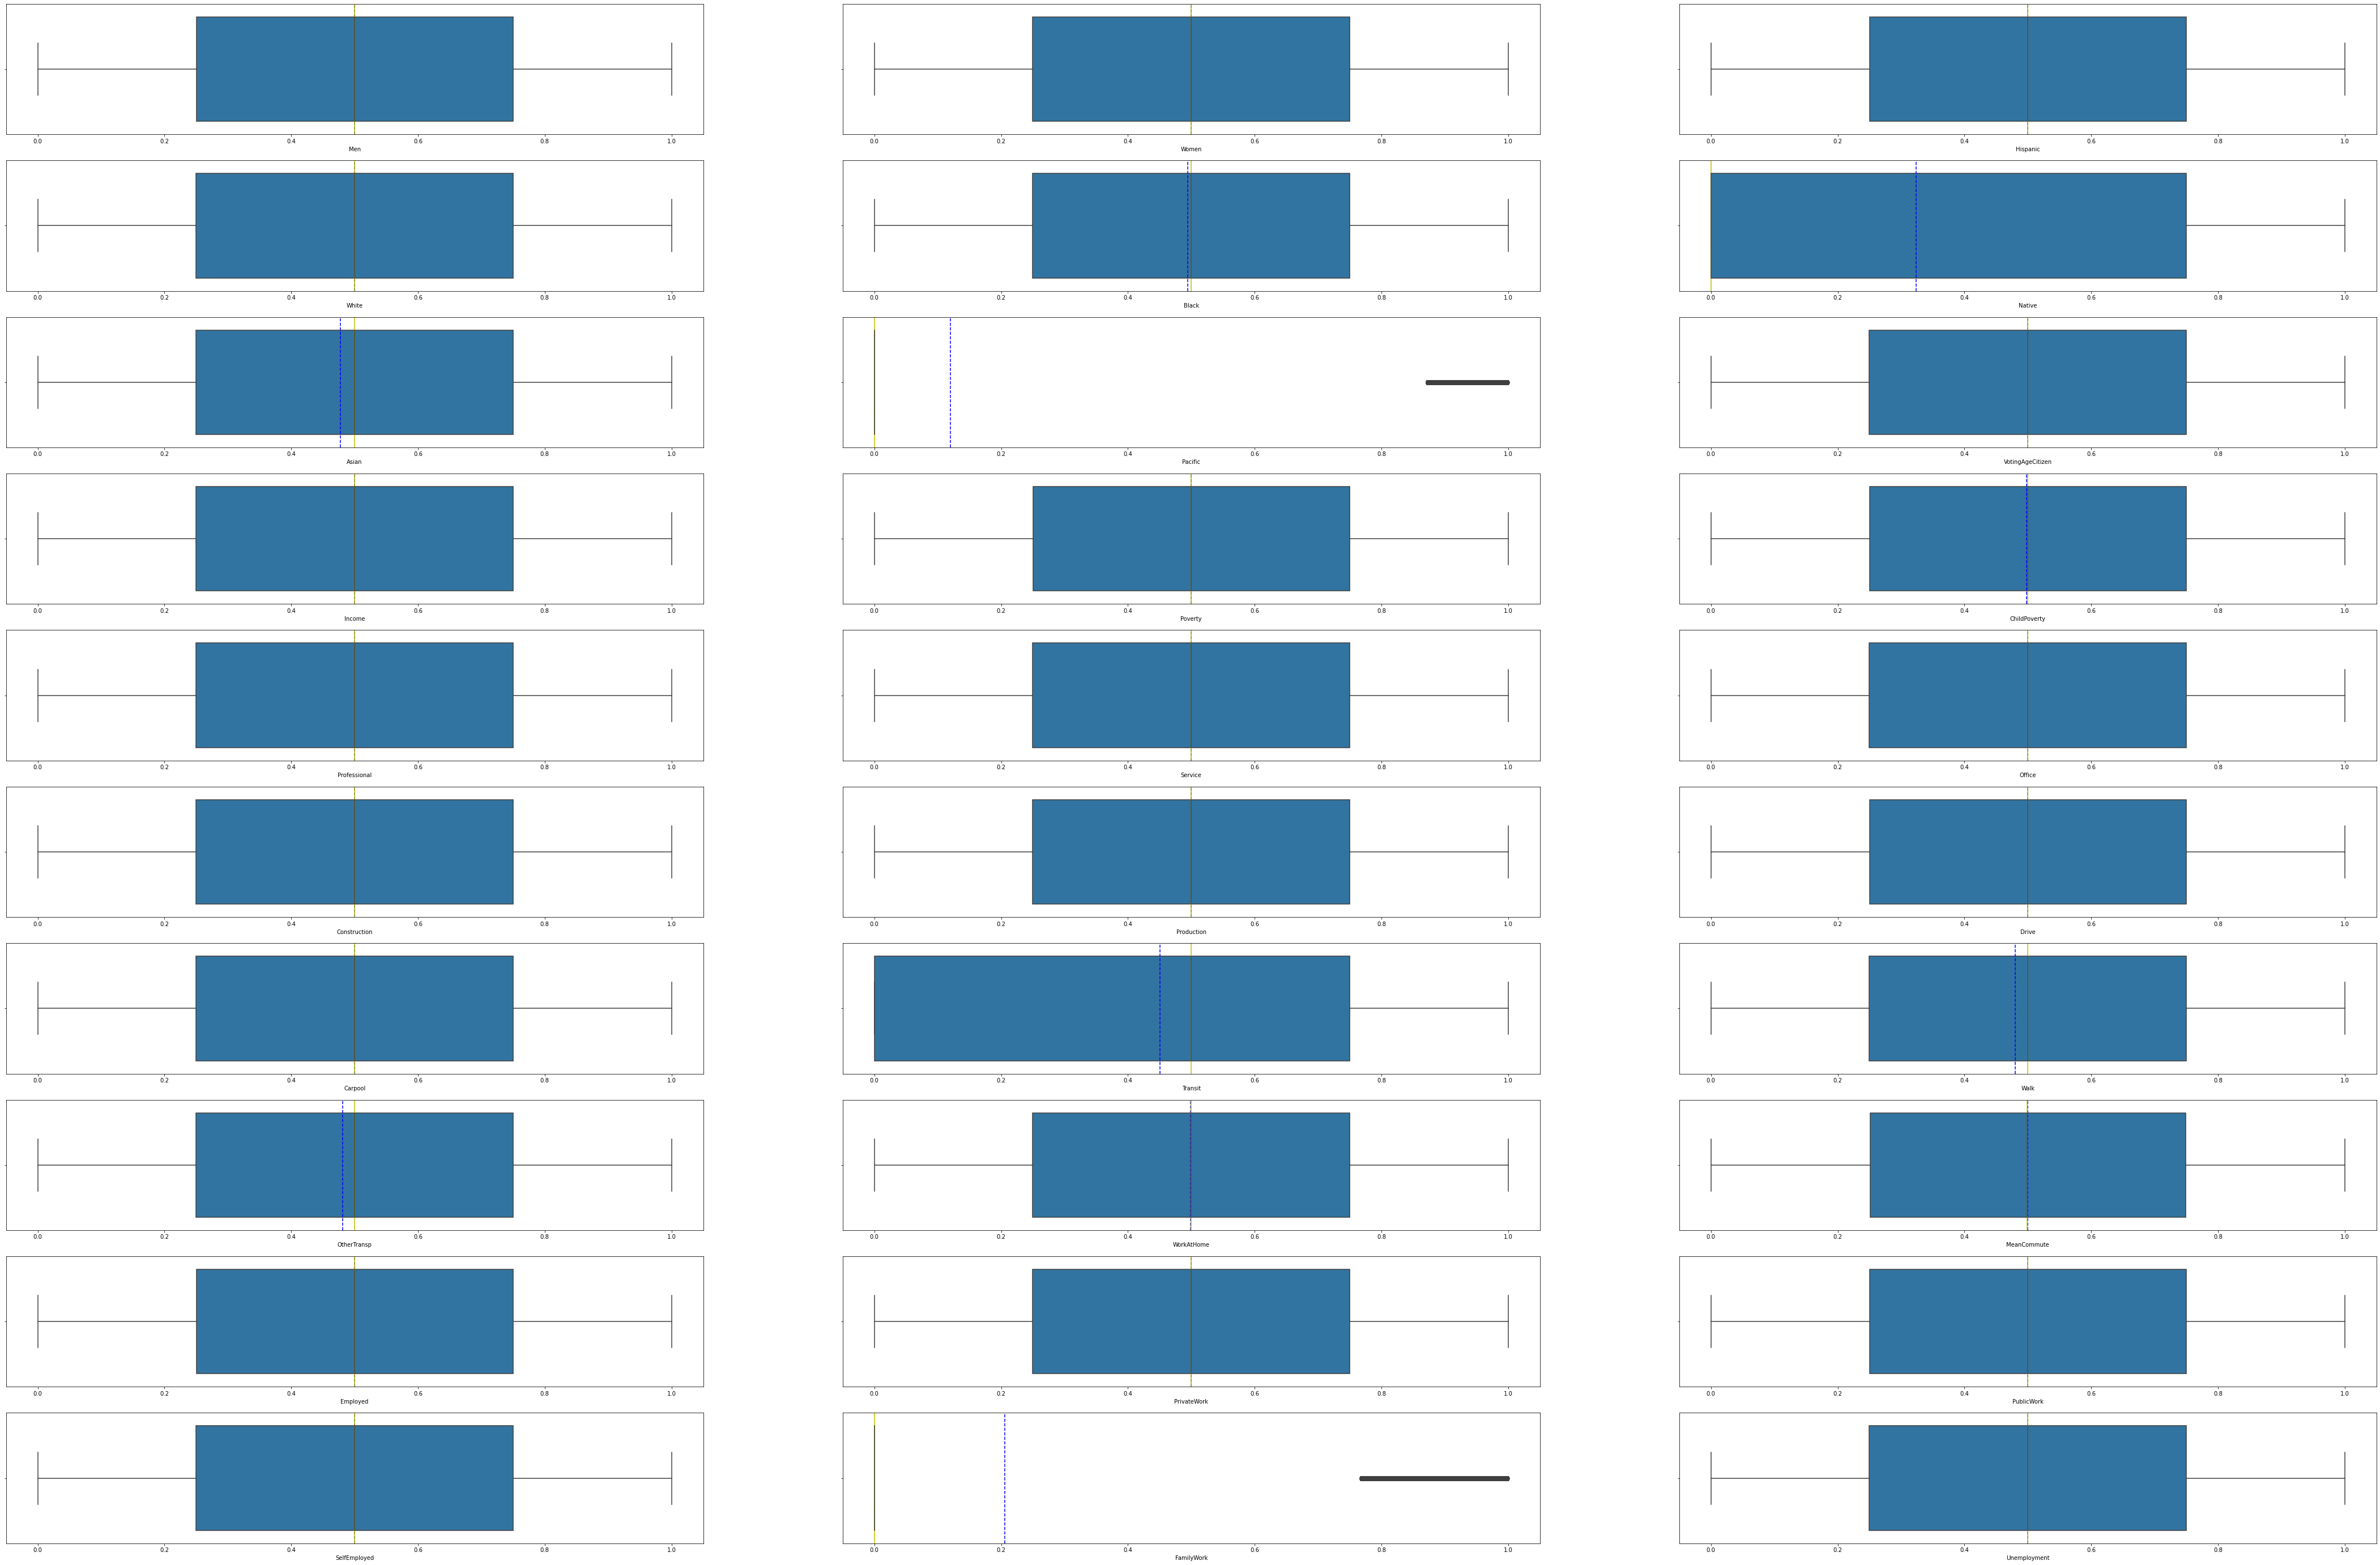

In [39]:
fig, axs = plt.subplots(10, 3, sharex=False, figsize=(75,50))


i = 0
for col in df_qt_trnsf.columns.to_list():
    # print(col)

    # Take the 25 and 75 percentile points. These points will be the body of the boxplot
    # From Q1 subtract 1.5 * IQR, which will be the lower whisker
    # From Q3 add 1.5 * IQR, which will be the upper whisker
    Q1 = df_qt_trnsf[col].quantile(0.25)
    Q3 = df_qt_trnsf[col].quantile(0.75)

    IQR = Q3 - Q1
    lower = Q1 - IQR
    upper = Q3 + IQR

    num_out_lower = len(df_qt_trnsf[df_qt_trnsf < lower])
    num_out_upper = len(df_qt_trnsf[df_qt_trnsf > upper])

    mean = df_qt_trnsf[col].mean()
    median = df_qt_trnsf[col].median()

    # Plotting the boxplots

    plt_row = int(i/3)
    plt_col = (i % 3)
    i += 1
    axs_obj = axs[plt_row, plt_col]
    sns.boxplot(df_qt_trnsf[col], ax=axs_obj)
    axs_obj.axvline(mean, color = 'b', linestyle='--')
    axs_obj.axvline(median, color = 'y', linestyle='-')
    # print(axs_obj)


**Conclusion** Using quantile transformation the data looks to be normalised uniformly

## Outcome of Data Exploration and creating the Features and Target Datasets

There are a lot of outliers in the data, and Quantile Transformation has uniformly distributed and normalised the data, so we will go ahead with the transformed data

In [40]:
X = df_qt_trnsf.drop(columns='Income').copy()
y = df_qt_trnsf['Income']

y.shape

(73305,)

# Feature Engineering

### Check the correlation matrix for the transformed data

<AxesSubplot:>

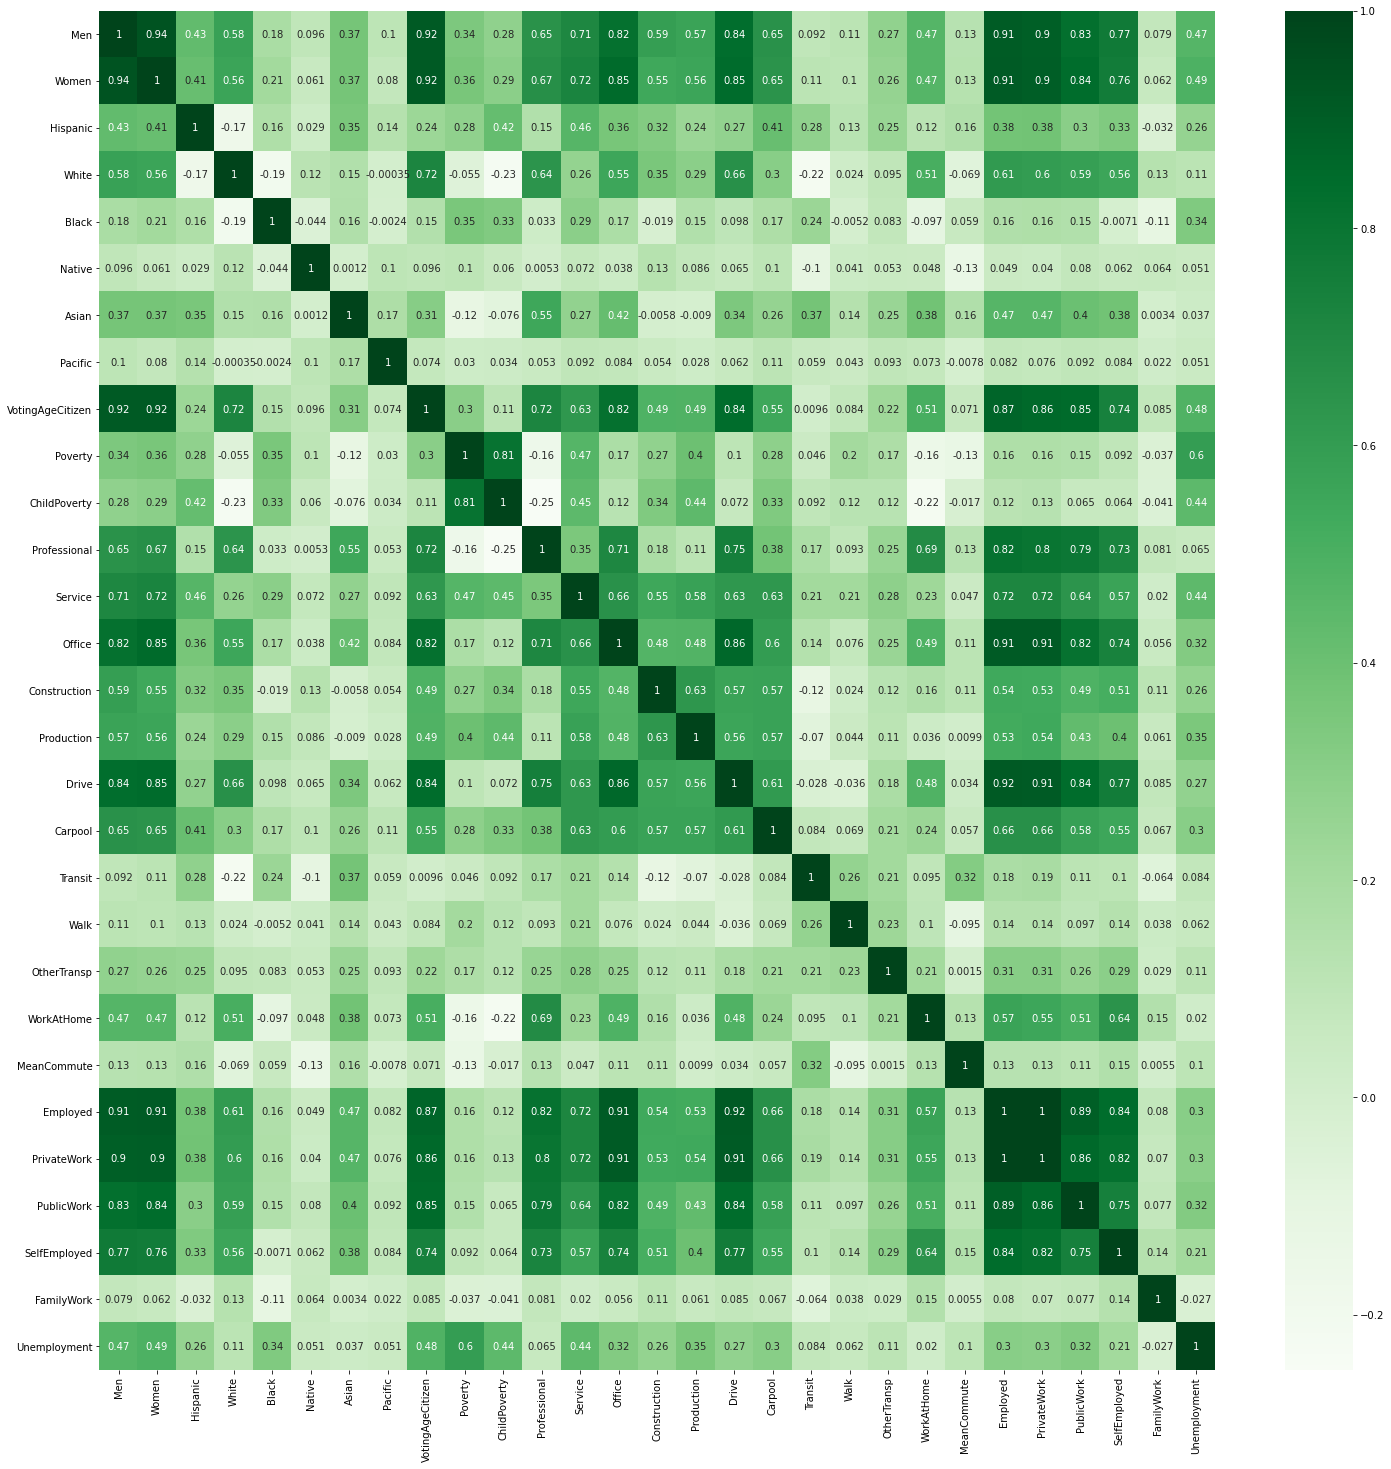

In [41]:
plt.figure(figsize=(25, 25))
corr = X.corr()
sns.heatmap(corr, annot=True, robust=False, cmap="Greens")

**Conclusion** The features are not highly correlated, we will not need any inter-column transformation

Plot the correlation with the target values

In [42]:
# fig, axs = plt.subplots(10, 3, sharex=False, figsize=(75,50))


i = 0
for col in X.columns.to_list():

    df_pair = df_qt_trnsf.loc[:, ['Income', col]]

    # # Plotting the scatterplots - Commenting for now because it takes a lot of time

    # plt_row = int(i/3)
    # plt_col = (i % 3)
    # i += 1
    # axs_obj = axs[plt_row, plt_col]

    # sns.scatterplot(x=df_pair[col], y=df_pair['Income'], ax=axs_obj)
        


### Using Sequential Forward Selection 

In [43]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS 
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor, RandomForestRegressor

In [44]:
sfs = SFS(LinearRegression(), n_features_to_select=20, direction='forward', scoring='r2', cv=5, n_jobs=4)

sfs = sfs.fit(np.array(X), y)

In [45]:
sfs.get_support(1)
sfs_features = X.columns[sfs.get_support(1)]
sfs_features

Index(['Men', 'Women', 'Black', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office',
       'Construction', 'Production', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PublicWork', 'FamilyWork'],
      dtype='object')

### Using Sequential Backward Elimination

In [46]:
sbs = SFS(LinearRegression(), n_features_to_select=20, direction='backward', scoring='r2', cv=5, n_jobs=4)

sbs = sbs.fit(np.array(X), y)

In [47]:
sbs.get_support(1)
sbs_features = X.columns[sbs.get_support(1)]
sbs_features

Index(['Men', 'Women', 'Black', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Poverty', 'ChildPoverty', 'Professional', 'Service', 'Construction',
       'Production', 'Walk', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork'],
      dtype='object')

### Using a RandomForestRegressor and getting feature importances

In [48]:
forest = RandomForestRegressor() # Default Params
forest.fit(X, y)

RandomForestRegressor()

In [49]:
forest.feature_importances_

array([0.01308562, 0.00585782, 0.00548151, 0.00638222, 0.00781956,
       0.00252987, 0.00759113, 0.00173118, 0.01053596, 0.36359266,
       0.00803032, 0.45400239, 0.00754729, 0.00510988, 0.00662831,
       0.01044607, 0.00799592, 0.00524494, 0.00435424, 0.0057359 ,
       0.00446073, 0.00734961, 0.02007657, 0.00425602, 0.0036575 ,
       0.00817335, 0.00538603, 0.00145426, 0.0054831 ])

### Using Recursive Feature Elimination

In [50]:
from sklearn.feature_selection import  RFECV

In [51]:
rfe = RFECV(LinearRegression(), min_features_to_select=20, cv=5, scoring= 'r2', n_jobs= 4 )

rfe.fit(np.array(X), y)

RFECV(cv=5, estimator=LinearRegression(), min_features_to_select=20, n_jobs=4,
      scoring='r2')

In [52]:
rfe.get_support(1)
rfe_features = X.columns[rfe.get_support(1)]
rfe_features

Index(['Men', 'Women', 'Hispanic', 'White', 'Black', 'Asian', 'Pacific',
       'VotingAgeCitizen', 'Poverty', 'ChildPoverty', 'Professional',
       'Service', 'Office', 'Production', 'Drive', 'Walk', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed'],
      dtype='object')

### Using SelectKBest

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression

In [54]:
kbest = SelectKBest(score_func = f_regression, k = 20   ) 
features = kbest.fit(X,y)

#Get the feature names
feature_name =  kbest.get_support(1)
X_new = X[X.columns[feature_name]] 
kbest_feature = X_new.columns

print("Best 20 features using K-best algorithm - ",kbest_feature)

Best 20 features using K-best algorithm -  Index(['Men', 'Women', 'White', 'Black', 'Asian', 'VotingAgeCitizen',
       'Poverty', 'ChildPoverty', 'Professional', 'Office', 'Production',
       'Drive', 'Walk', 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork',
       'PublicWork', 'SelfEmployed', 'Unemployment'],
      dtype='object')


### Consolidating the results from the different feature engg methods

In [55]:
df_summary = pd.DataFrame(columns=['Feat_sel_method', 'Best_features'], index=None)

In [56]:
df_summary = df_summary.append(pd.Series(['SFS', sfs_features], index=df_summary.columns), ignore_index=True)

In [57]:
df_summary = df_summary.append(pd.Series(['SBS', sbs_features], index=df_summary.columns), ignore_index=True)

In [58]:
df_forest_features = pd.DataFrame( {'Features': X.columns, 'Importance':forest.feature_importances_})
df_forest_features.sort_values(by='Importance', ascending=False, inplace=True)
df_forest_features = df_forest_features.iloc[:20, : ]
forest_features = df_forest_features.Features.to_list()
df_summary = df_summary.append(pd.Series(['RandomForest', forest_features], index=df_summary.columns), ignore_index=True)

In [59]:
df_summary = df_summary.append(pd.Series(['RFE', rfe_features], index=df_summary.columns), ignore_index=True)

In [60]:
kbest_features = kbest_feature.to_list()
df_summary = df_summary.append(pd.Series(['SelectKBest', kbest_features], index=df_summary.columns), ignore_index=True)

In [61]:
df_summary

,Feat_sel_method,Best_features
0,SFS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci..."
1,SBS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci..."
2,RandomForest,"[Professional, Poverty, MeanCommute, Men, Voti..."
3,RFE,"Index(['Men', 'Women', 'Hispanic', 'White', 'B..."
4,SelectKBest,"[Men, Women, White, Black, Asian, VotingAgeCit..."


In [62]:
from functools import reduce

In [63]:
all_features = [sfs_features] + [sbs_features]  + [forest_features] + [rfe_features] + [kbest_features]
common_features = reduce(np.intersect1d,all_features)

In [64]:
common_features

array(['Asian', 'Black', 'ChildPoverty', 'MeanCommute', 'Men', 'Poverty',
       'Production', 'Professional', 'PublicWork', 'VotingAgeCitizen',
       'Walk', 'Women', 'WorkAtHome'], dtype=object)

In [65]:
df_summary = df_summary.append(pd.Series(['CommonFeatures', common_features], index=df_summary.columns), ignore_index=True)

In [66]:
df_summary

,Feat_sel_method,Best_features
0,SFS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci..."
1,SBS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci..."
2,RandomForest,"[Professional, Poverty, MeanCommute, Men, Voti..."
3,RFE,"Index(['Men', 'Women', 'Hispanic', 'White', 'B..."
4,SelectKBest,"[Men, Women, White, Black, Asian, VotingAgeCit..."
5,CommonFeatures,"[Asian, Black, ChildPoverty, MeanCommute, Men,..."


# Model Selection Step1: Running Cross Validation Scoring on all Models

### Running models with baseline configs

In [67]:
from sklearn.model_selection import cross_val_score

### LinearRegression

In [68]:
df_summary['LinearRegression'] = 0
for method in df_summary.Feat_sel_method:

    # print(method)
    features_list = df_summary.loc[ df_summary.Feat_sel_method == method, 'Best_features'].squeeze()
    # print((features_list))
    X_method = X.loc[:, features_list].copy()
    # print(X_method.shape)

    model = LinearRegression()
    cross_vals = cross_val_score(model, X_method, y, cv= 5, n_jobs= 4 )
    cv_mean = cross_vals.mean()
    cv_std = cross_vals.std()

    # Store in the DF
    df_summary.loc[df_summary.Feat_sel_method == method, 'LinearRegression'] = str(round(cv_mean, 4)) + ' - ' + str(round(cv_std, 3))


In [69]:
df_summary

,Feat_sel_method,Best_features,LinearRegression
0,SFS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci...",0.8093 - 0.018
1,SBS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci...",0.8097 - 0.018
2,RandomForest,"[Professional, Poverty, MeanCommute, Men, Voti...",0.8058 - 0.02
3,RFE,"Index(['Men', 'Women', 'Hispanic', 'White', 'B...",0.8071 - 0.019
4,SelectKBest,"[Men, Women, White, Black, Asian, VotingAgeCit...",0.8056 - 0.02
5,CommonFeatures,"[Asian, Black, ChildPoverty, MeanCommute, Men,...",0.8071 - 0.019


### Ridge Regressor

In [70]:
from sklearn.linear_model import Ridge

In [71]:
df_summary['Ridge'] = 0
for method in df_summary.Feat_sel_method:

    # print(method)
    features_list = df_summary.loc[ df_summary.Feat_sel_method == method, 'Best_features'].squeeze()
    # print((features_list))
    X_method = X.loc[:, features_list].copy()
    print(X_method.shape)

    model = Ridge()
    
    cross_vals = cross_val_score(model, X_method, y, cv= 5, n_jobs= 4 )
    cv_mean = cross_vals.mean()
    cv_std = cross_vals.std()

    df_summary.loc[df_summary.Feat_sel_method == method, 'Ridge'] = str(round(cv_mean, 4)) + ' - ' + str(round(cv_std, 3))


(73305, 20)
(73305, 20)
(73305, 20)
(73305, 22)
(73305, 20)
(73305, 13)


In [72]:
df_summary

,Feat_sel_method,Best_features,LinearRegression,Ridge
0,SFS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci...",0.8093 - 0.018,0.8093 - 0.018
1,SBS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci...",0.8097 - 0.018,0.8097 - 0.018
2,RandomForest,"[Professional, Poverty, MeanCommute, Men, Voti...",0.8058 - 0.02,0.8058 - 0.02
3,RFE,"Index(['Men', 'Women', 'Hispanic', 'White', 'B...",0.8071 - 0.019,0.8071 - 0.019
4,SelectKBest,"[Men, Women, White, Black, Asian, VotingAgeCit...",0.8056 - 0.02,0.8056 - 0.02
5,CommonFeatures,"[Asian, Black, ChildPoverty, MeanCommute, Men,...",0.8071 - 0.019,0.8071 - 0.019


### RandomForestRegressor

In [ ]:
df_summary['RandomForestRegressor'] = 0
for method in df_summary.Feat_sel_method:

    # print(method)
    features_list = df_summary.loc[ df_summary.Feat_sel_method == method, 'Best_features'].squeeze()
    # print((features_list))
    X_method = X.loc[:, features_list].copy()
    print(X_method.shape)

    model = RandomForestRegressor()

    cross_vals = cross_val_score(model, X_method, y, cv= 5, n_jobs= 4 )
    cv_mean = cross_vals.mean()
    cv_std = cross_vals.std()

    df_summary.loc[df_summary.Feat_sel_method == method, 'RandomForestRegressor'] = str(round(cv_mean, 4)) + ' - ' + str(round(cv_std, 3))

### DecisionTreeRegressor

In [73]:
from sklearn.tree import DecisionTreeRegressor

In [74]:
df_summary['DecisionTree'] = 0
for method in df_summary.Feat_sel_method:

    # print(method)
    features_list = df_summary.loc[ df_summary.Feat_sel_method == method, 'Best_features'].squeeze()
    # print((features_list))
    X_method = X.loc[:, features_list].copy()
    print(X_method.shape)

    model = DecisionTreeRegressor()

    cross_vals = cross_val_score(model, X_method, y, cv= 5, n_jobs= 4 )
    cv_mean = cross_vals.mean()
    cv_std = cross_vals.std()

    df_summary.loc[df_summary.Feat_sel_method == method, 'DecisionTree'] = str(round(cv_mean, 4)) + ' - ' + str(round(cv_std, 3))

(73305, 20)
(73305, 20)
(73305, 20)
(73305, 22)
(73305, 20)
(73305, 13)


In [75]:
df_summary

,Feat_sel_method,Best_features,LinearRegression,Ridge,DecisionTree
0,SFS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci...",0.8093 - 0.018,0.8093 - 0.018,0.692 - 0.028
1,SBS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci...",0.8097 - 0.018,0.8097 - 0.018,0.6936 - 0.028
2,RandomForest,"[Professional, Poverty, MeanCommute, Men, Voti...",0.8058 - 0.02,0.8058 - 0.02,0.688 - 0.029
3,RFE,"Index(['Men', 'Women', 'Hispanic', 'White', 'B...",0.8071 - 0.019,0.8071 - 0.019,0.6933 - 0.03
4,SelectKBest,"[Men, Women, White, Black, Asian, VotingAgeCit...",0.8056 - 0.02,0.8056 - 0.02,0.6923 - 0.026
5,CommonFeatures,"[Asian, Black, ChildPoverty, MeanCommute, Men,...",0.8071 - 0.019,0.8071 - 0.019,0.6948 - 0.025


### AdaBoostRegressor

In [76]:
from sklearn.ensemble import AdaBoostRegressor

In [78]:
df_summary['AdaBoost'] = 0
for method in df_summary.Feat_sel_method:

    # print(method)
    features_list = df_summary.loc[ df_summary.Feat_sel_method == method, 'Best_features'].squeeze()
    # print((features_list))
    X_method = X.loc[:, features_list].copy()
    print(X_method.shape)

    model = AdaBoostRegressor()

    cross_vals = cross_val_score(model, X_method, y, cv= 5, n_jobs= 4 )
    cv_mean = cross_vals.mean()
    cv_std = cross_vals.std()

    df_summary.loc[df_summary.Feat_sel_method == method, 'AdaBoost'] = str(round(cv_mean, 4)) + ' - ' + str(round(cv_std, 3))

(73305, 20)
(73305, 20)
(73305, 20)
(73305, 22)
(73305, 20)
(73305, 13)


In [79]:
df_summary

,Feat_sel_method,Best_features,LinearRegression,Ridge,DecisionTree,AdaBoost
0,SFS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci...",0.8093 - 0.018,0.8093 - 0.018,0.692 - 0.028,0.6634 - 0.019
1,SBS,"Index(['Men', 'Women', 'Black', 'Asian', 'Paci...",0.8097 - 0.018,0.8097 - 0.018,0.6936 - 0.028,0.6648 - 0.023
2,RandomForest,"[Professional, Poverty, MeanCommute, Men, Voti...",0.8058 - 0.02,0.8058 - 0.02,0.688 - 0.029,0.6632 - 0.026
3,RFE,"Index(['Men', 'Women', 'Hispanic', 'White', 'B...",0.8071 - 0.019,0.8071 - 0.019,0.6933 - 0.03,0.6594 - 0.03
4,SelectKBest,"[Men, Women, White, Black, Asian, VotingAgeCit...",0.8056 - 0.02,0.8056 - 0.02,0.6923 - 0.026,0.6641 - 0.029
5,CommonFeatures,"[Asian, Black, ChildPoverty, MeanCommute, Men,...",0.8071 - 0.019,0.8071 - 0.019,0.6948 - 0.025,0.6628 - 0.011


### GradientBoostingRegressor

In [87]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
df_summary['GradBoost'] = 0
for method in df_summary.Feat_sel_method:

    # print(method)
    features_list = df_summary.loc[ df_summary.Feat_sel_method == method, 'Best_features'].squeeze()
    # print((features_list))
    X_method = X.loc[:, features_list].copy()
    print(X_method.shape)

    model = GradientBoostingRegressor()

    cross_vals = cross_val_score(model, X_method, y, cv= 5, n_jobs= 4 )
    cv_mean = cross_vals.mean()
    cv_std = cross_vals.std()

    df_summary.loc[df_summary.Feat_sel_method == method, 'GradBoost'] = str(round(cv_mean, 4)) + ' - ' + str(round(cv_std, 3))


In [ ]:
df_summary

### AdaBoost with Linear Regression as the base estimator instead of the default, which is trees

In [ ]:
df_summary['AdaBoost_LinReg'] = 0
for method in df_summary.Feat_sel_method:

    # print(method)
    features_list = df_summary.loc[ df_summary.Feat_sel_method == method, 'Best_features'].squeeze()
    # print((features_list))
    X_method = X.loc[:, features_list].copy()
    print(X_method.shape)

    model = AdaBoostRegressor(base_estimator= LinearRegression())

    cross_vals = cross_val_score(model, X_method, y, cv= 5, n_jobs= 4 )
    cv_mean = cross_vals.mean()
    cv_std = cross_vals.std()

    df_summary.loc[df_summary.Feat_sel_method == method, 'AdaBoost_LinReg'] = str(round(cv_mean, 4)) + ' - ' + str(round(cv_std, 3))


In [ ]:
df_summary

In [ ]:
df_summary.to_csv('Cross_val_scores.csv')

### Running for all features (the entire dataset)

In [ ]:
# Lets run for all features together

df_summary = df_summary.append(pd.Series([ 
                        'AllFeatures',
                        X.columns.to_list(),
                        0, 0, 0, 0, 0, 0, 0
                ], index=df_summary.columns), ignore_index=True)

In [ ]:
df_summary

In [ ]:
method = 'AllFeatures'

# print(method)
features_list = df_summary.loc[ df_summary.Feat_sel_method == method, 'Best_features'].squeeze()
# print((features_list))
X_method = X.loc[:, features_list].copy()

linreg = LinearRegression()
scores = cross_val_score(linreg, X_method, y, cv= 5, n_jobs=4 )
linreg_score = str(round(scores.mean(), 4)) + ' - ' + str(round(scores.std(), 3 ))

ridge = Ridge()
scores = cross_val_score(ridge, X_method, y, cv= 5, n_jobs=4 )
ridge_score = str(round(scores.mean(), 4)) + ' - ' + str(round(scores.std(), 3 ))
 
forest = RandomForestRegressor()
scores = cross_val_score(forest, X_method, y, cv= 5, n_jobs=4 )
forest_score = str(round(scores.mean(), 4)) + ' - ' + str(round(scores.std(), 3 ))

tree = DecisionTreeRegressor()
scores = cross_val_score(tree, X_method, y, cv= 5, n_jobs=4 )
tree_score = str(round(scores.mean(), 4)) + ' - ' + str(round(scores.std(), 3 ))

ada = AdaBoostRegressor()
scores = cross_val_score(ada, X_method, y, cv= 5, n_jobs=4 )
ada_score = str(round(scores.mean(), 4)) + ' - ' + str(round(scores.std(), 3 ))

grad = GradientBoostingRegressor()
scores = cross_val_score(grad, X_method, y, cv= 5, n_jobs=4 )
grad_score = str(round(scores.mean(), 4)) + ' - ' + str(round(scores.std(), 3 ))

ada_lin = AdaBoostRegressor(LinearRegression())
scores = cross_val_score(ada_lin, X_method, y, cv= 5, n_jobs=4 )
ada_lin_score = str(round(scores.mean(), 4)) + ' - ' + str(round(scores.std(), 3 ))

df_summary.loc[df_summary.Feat_sel_method == method, 'LinearRegression'] = linreg_score
df_summary.loc[df_summary.Feat_sel_method == method, 'Ridge'] = ridge_score
df_summary.loc[df_summary.Feat_sel_method == method, 'RandomForestRegressor'] = forest_score
df_summary.loc[df_summary.Feat_sel_method == method, 'DecisionTree'] = tree_score
df_summary.loc[df_summary.Feat_sel_method == method, 'AdaBoost'] = ada_score
df_summary.loc[df_summary.Feat_sel_method == method, 'GradBoost'] = grad_score
df_summary.loc[df_summary.Feat_sel_method == method, 'AdaBoost_LinReg'] = ada_lin_score


In [ ]:
df_summary

In [ ]:
df_summary.to_csv('Cross_val_scores.csv')

### **Conclusion**

The feature selection method SBS and the baseline model RandomForestRegressor has given the best R2 score with a good Standard Deviation. We will be using them for model tuning 

## HyperParameter Optimization

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
features_list = sbs_features.to_list()
print((features_list))
X_grid = X.loc[:, features_list].copy()
X_grid.shape

['Men', 'Women', 'Black', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Poverty', 'ChildPoverty', 'Professional', 'Service', 'Construction', 'Production', 'Walk', 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork']


(73305, 20)

### GridSearch with RandomForestRegressor

In [ ]:
forest = RandomForestRegressor()

params = {}
params['n_estimators'] = [1000, 1200]
params['max_depth'] = [80, 90 , 100]
params['warm_start'] = [True]
params['max_samples'] = [0.2, 0.3]
params['max_features'] = ['auto', 'sqrt']

In [ ]:
grid = GridSearchCV(forest, params, cv=5, n_jobs=4, verbose=2 )

grid.fit(X_grid, y)


In [ ]:
print(f'Score: {grid.best_score_}')
print(f'Best params: {grid.best_params_}')
estimator = grid.best_estimator_

grid_best_params = str(grid.best_params_)
grid_best_params
gridcv_best_score = grid.best_score_


### GridSearch with AdaBoost models

Since RandomForests have given good outcomes we'll try AdaBoost with DecisionTrees as the base estimator

In [82]:
ada_boost_line = AdaBoostRegressor()

params = {}
params['base_estimator'] = [DecisionTreeRegressor()]       
params['n_estimators'] = [100, 200, 300, 1000]               
params['learning_rate'] = [0.1, 0.5, 1, 2]               


In [83]:
grid = GridSearchCV(ada_boost_line, params, cv=5, n_jobs=4, verbose=2 )

grid.fit(X_grid, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=AdaBoostRegressor(), n_jobs=4,
             param_grid={'base_estimator': [DecisionTreeRegressor()],
                         'learning_rate': [0.1, 0.5, 1, 2],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [84]:
print(f'Score: {grid.best_score_}')
print(f'Best params: {grid.best_params_}')
estimator = grid.best_estimator_

grid_best_params = str(grid.best_params_)
grid_best_params
gridcv_best_score = grid.best_score_

Score: 0.8583947860919607
Best params: {'base_estimator': DecisionTreeRegressor(), 'learning_rate': 2, 'n_estimators': 1000}


### GridSearch with GradientBoostingRegressor

In [97]:
grad_boost = GradientBoostingRegressor()

params = {}
params['n_estimators'] = [1500]               
params['learning_rate'] = [0.1, 0.25]      
params['criterion'] = ['friedman_mse']         

In [98]:
grid = GridSearchCV(grad_boost, params, cv=5, n_jobs=4, verbose=2 )

grid.fit(X_grid, y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
print(f'Score: {grid.best_score_}')
print(f'Best params: {grid.best_params_}')
estimator = grid.best_estimator_

grid_best_params = str(grid.best_params_)
grid_best_params
gridcv_best_score = grid.best_score_

Score: 0.8608031294003433
Best params: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'n_estimators': 1500}
